In [1]:
# =====================================================================
# Step 1: Environment Setup for Deep Learning Pipeline
# ---------------------------------------------------------------------
# Objectives:
#   1. Verify that preprocessed and engineered data artifacts exist.
#   2. Prepare directories for deep learning models and outputs.
# =====================================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import joblib
from pathlib import Path
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Directory Setup
# ---------------------------------------------------------------------
ROOT = Path(".").resolve()
DATA_DIR = ROOT / "BODMAS"
ART_DIR = ROOT / "artifacts"
MODEL_DIR = ROOT / "models" / "deep_learning"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Verify required artifacts
required_files = [
    "X_train_enh.parquet",
    "X_val_enh.parquet",
    "X_test_enh.parquet",
    "Xy_splits.npz"
]
missing = [f for f in required_files if not (ART_DIR / f).exists()]
if missing:
    raise FileNotFoundError(f"Missing required file(s): {missing}")

print("Environment verified successfully.")
print("Artifacts directory:", ART_DIR)
print("Model output directory:", MODEL_DIR)

# ---------------------------------------------------------------------
# Load Feature Matrices
# ---------------------------------------------------------------------
X_train = pd.read_parquet(ART_DIR / "X_train_enh.parquet")
X_val   = pd.read_parquet(ART_DIR / "X_val_enh.parquet")
X_test  = pd.read_parquet(ART_DIR / "X_test_enh.parquet")

npz = np.load(ART_DIR / "Xy_splits.npz", allow_pickle=True)
y = npz["y"]

print(f"Loaded: X_train {X_train.shape}, X_val {X_val.shape}, X_test {X_test.shape}")
print("Artifacts ready for deep learning pipeline.")

Environment verified successfully.
Artifacts directory: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/artifacts
Model output directory: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/deep_learning
Loaded: X_train (91501, 4765), X_val (19608, 4765), X_test (19607, 4765)
Artifacts ready for deep learning pipeline.


In [3]:
# =====================================================================
# Step 2 (Fixed): Prepare PyTorch Datasets and DataLoaders
# ---------------------------------------------------------------------
# Align malware family labels to full dataset indices.
# =====================================================================

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Load binary labels and splits
npz = np.load(ART_DIR / "Xy_splits.npz", allow_pickle=True)
y_binary = npz["y"].astype(int)
idx_train, idx_val, idx_test = npz["idx_train"], npz["idx_val"], npz["idx_test"]

# ---------------------------------------------------------------------
# Load malware family metadata and align with full sample count
# ---------------------------------------------------------------------
meta = pd.read_csv(DATA_DIR / "bodmas_malware_category.csv")

# Align length to feature matrix (same as binary labels)
meta = meta.reindex(range(len(y_binary)), fill_value=np.nan)
meta["category"] = meta["category"].fillna("Benign")

label_encoder_family = LabelEncoder()
y_family = label_encoder_family.fit_transform(meta["category"].astype(str))

# ---------------------------------------------------------------------
# Convert features and labels to tensors
# ---------------------------------------------------------------------
def to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

X_train_t = to_tensor(X_train)
X_val_t   = to_tensor(X_val)
X_test_t  = to_tensor(X_test)

y_train_bin_t = torch.tensor(y_binary[idx_train], dtype=torch.long)
y_val_bin_t   = torch.tensor(y_binary[idx_val], dtype=torch.long)
y_test_bin_t  = torch.tensor(y_binary[idx_test], dtype=torch.long)

y_train_fam_t = torch.tensor(y_family[idx_train], dtype=torch.long)
y_val_fam_t   = torch.tensor(y_family[idx_val], dtype=torch.long)
y_test_fam_t  = torch.tensor(y_family[idx_test], dtype=torch.long)

# ---------------------------------------------------------------------
# Build DataLoaders
# ---------------------------------------------------------------------
def make_loader(X, y, batch_size=256, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader_bin = make_loader(X_train_t, y_train_bin_t)
val_loader_bin   = make_loader(X_val_t,   y_val_bin_t,   shuffle=False)
test_loader_bin  = make_loader(X_test_t,  y_test_bin_t,  shuffle=False)

train_loader_fam = make_loader(X_train_t, y_train_fam_t)
val_loader_fam   = make_loader(X_val_t,   y_val_fam_t,   shuffle=False)
test_loader_fam  = make_loader(X_test_t,  y_test_fam_t,  shuffle=False)

print("DataLoaders prepared successfully:")
print(f"  Binary  -> Train: {len(train_loader_bin.dataset)}, Val: {len(val_loader_bin.dataset)}, Test: {len(test_loader_bin.dataset)}")
print(f"  Family  -> Train: {len(train_loader_fam.dataset)}, Val: {len(val_loader_fam.dataset)}, Test: {len(test_loader_fam.dataset)}")

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

DataLoaders prepared successfully:
  Binary  -> Train: 91501, Val: 19608, Test: 19607
  Family  -> Train: 91501, Val: 19608, Test: 19607
Using device: mps



Training Binary MLP...
Epoch 01: Train Loss=0.5173 | Val Loss=0.3784 | Val Acc=82.07%
Epoch 02: Train Loss=0.4786 | Val Loss=0.9010 | Val Acc=72.77%
Epoch 03: Train Loss=0.4623 | Val Loss=0.3349 | Val Acc=84.41%
Epoch 04: Train Loss=0.4504 | Val Loss=0.4993 | Val Acc=67.92%
Epoch 05: Train Loss=0.4389 | Val Loss=0.4117 | Val Acc=75.52%
Epoch 06: Train Loss=0.4281 | Val Loss=0.7368 | Val Acc=68.49%
Epoch 07: Train Loss=0.4215 | Val Loss=0.3412 | Val Acc=84.49%
Epoch 08: Train Loss=0.4183 | Val Loss=0.5545 | Val Acc=66.69%
Epoch 09: Train Loss=0.4086 | Val Loss=0.5668 | Val Acc=67.60%
Epoch 10: Train Loss=0.4018 | Val Loss=0.3373 | Val Acc=83.02%
Epoch 11: Train Loss=0.3964 | Val Loss=0.3492 | Val Acc=84.59%
Epoch 12: Train Loss=0.3909 | Val Loss=0.4123 | Val Acc=80.88%
Epoch 13: Train Loss=0.3850 | Val Loss=0.4180 | Val Acc=73.65%
Epoch 14: Train Loss=0.3804 | Val Loss=0.3649 | Val Acc=79.98%
Epoch 15: Train Loss=0.3765 | Val Loss=0.6502 | Val Acc=68.21%
Epoch 16: Train Loss=0.3734 | V

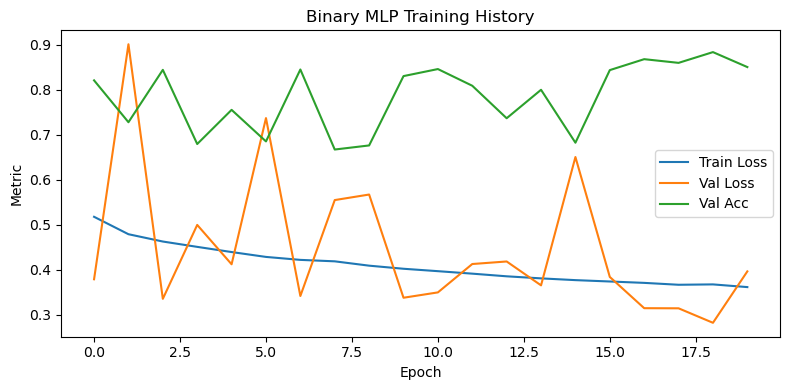

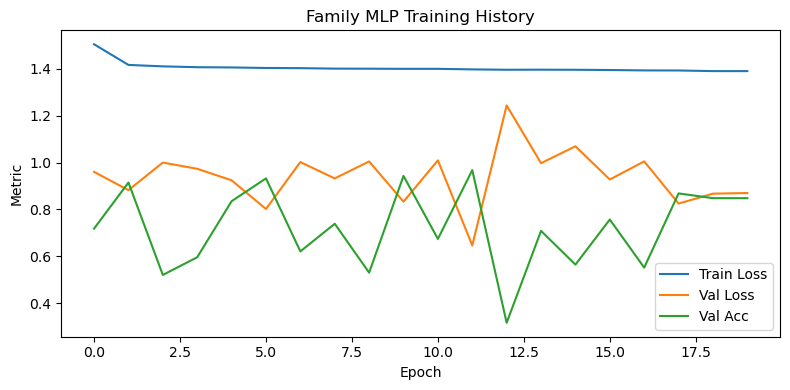

MLP models trained and saved successfully.


In [4]:
# =====================================================================
# Step 3: Multi-Layer Perceptron (MLP) for Malware Detection & Classification
# ---------------------------------------------------------------------
# Simple fully-connected neural network for tabular data.
# =====================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ---------------------------------------------------------------------
# Define generic MLP architecture
# ---------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[512, 256, 128], dropout=0.3):
        super(MLP, self).__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(last_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            last_dim = h
        layers.append(nn.Linear(last_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ---------------------------------------------------------------------
# Generic training & evaluation functions
# ---------------------------------------------------------------------
def train_model(model, loaders, criterion, optimizer, epochs=20, device="cpu"):
    """Train model with validation monitoring."""
    train_loader, val_loader = loaders
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # ---- Validation ----
        model.eval()
        correct, val_loss = 0, 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                preds = outputs.argmax(1)
                correct += (preds == y_val).sum().item()

        acc = correct / len(val_loader.dataset)
        history["train_loss"].append(total_loss / len(train_loader))
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(acc)

        print(f"Epoch {epoch+1:02d}: "
              f"Train Loss={history['train_loss'][-1]:.4f} | "
              f"Val Loss={history['val_loss'][-1]:.4f} | "
              f"Val Acc={acc*100:.2f}%")

    return model, history


def evaluate_model(model, loader, criterion, device="cpu"):
    """Evaluate on test set."""
    model.eval()
    correct, total_loss = 0, 0.0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
    acc = correct / len(loader.dataset)
    return acc, total_loss / len(loader)

# ---------------------------------------------------------------------
# Binary Malware Detection
# ---------------------------------------------------------------------
input_dim = X_train_t.shape[1]
num_classes_bin = 2

mlp_bin = MLP(input_dim, num_classes_bin)
criterion_bin = nn.CrossEntropyLoss()
optimizer_bin = optim.Adam(mlp_bin.parameters(), lr=1e-3)

print("\nTraining Binary MLP...")
mlp_bin, hist_bin = train_model(
    mlp_bin,
    (train_loader_bin, val_loader_bin),
    criterion_bin,
    optimizer_bin,
    epochs=20,
    device=device
)

# Evaluate on test set
test_acc_bin, test_loss_bin = evaluate_model(mlp_bin, test_loader_bin, criterion_bin, device=device)
print(f"Binary Test Accuracy: {test_acc_bin*100:.2f}%")

# Save model
torch.save(mlp_bin.state_dict(), MODEL_DIR / "mlp_binary.pth")


# ---------------------------------------------------------------------
# Multi-Class (Family) Classification
# ---------------------------------------------------------------------
num_classes_fam = len(label_encoder_family.classes_)
mlp_fam = MLP(input_dim, num_classes_fam)
criterion_fam = nn.CrossEntropyLoss()
optimizer_fam = optim.Adam(mlp_fam.parameters(), lr=1e-3)

print("\nTraining Family MLP...")
mlp_fam, hist_fam = train_model(
    mlp_fam,
    (train_loader_fam, val_loader_fam),
    criterion_fam,
    optimizer_fam,
    epochs=20,
    device=device
)

# Evaluate on test set
test_acc_fam, test_loss_fam = evaluate_model(mlp_fam, test_loader_fam, criterion_fam, device=device)
print(f"Family Test Accuracy: {test_acc_fam*100:.2f}%")

torch.save(mlp_fam.state_dict(), MODEL_DIR / "mlp_family.pth")

# ---------------------------------------------------------------------
# Plot training history
# ---------------------------------------------------------------------
def plot_history(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(hist_bin, "Binary MLP Training History")
plot_history(hist_fam, "Family MLP Training History")

print("MLP models trained and saved successfully.")

In [5]:
# =====================================================================
# Step 4: ResNet1D for Malware Detection & Classification
# ---------------------------------------------------------------------
# Deeper 1D convolutional architecture for structured malware features.
# =====================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---------------------------------------------------------------------
# Define a simple 1D residual block
# ---------------------------------------------------------------------
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


# ---------------------------------------------------------------------
# Define ResNet1D Model
# ---------------------------------------------------------------------
class ResNet1D(nn.Module):
    def __init__(self, input_dim, num_classes, base_channels=64):
        super(ResNet1D, self).__init__()
        self.input_dim = input_dim
        self.in_channels = base_channels

        # Input: [batch_size, 1, input_dim]
        self.conv1 = nn.Conv1d(1, base_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(base_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(base_channels, 2)
        self.layer2 = self._make_layer(base_channels * 2, 2, stride=2)
        self.layer3 = self._make_layer(base_channels * 4, 2, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(base_channels * 4, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock1D(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.unsqueeze(1)  # add channel dimension
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ---------------------------------------------------------------------
# Training configuration
# ---------------------------------------------------------------------
def train_resnet(model, loaders, criterion, optimizer, scheduler, epochs=25, patience=5, device="cpu"):
    train_loader, val_loader = loaders
    best_val_loss = float("inf")
    counter = 0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val).item()
                preds = outputs.argmax(1)
                correct += (preds == y_val).sum().item()

        val_acc = correct / len(val_loader.dataset)
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1:02d}: Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f} | ValAcc={val_acc*100:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, history


def evaluate_resnet(model, loader, criterion, device="cpu"):
    model.eval()
    correct, total_loss = 0, 0.0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            total_loss += criterion(outputs, y).item()
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
    acc = correct / len(loader.dataset)
    return acc, total_loss / len(loader)


# ---------------------------------------------------------------------
# Train Binary ResNet1D
# ---------------------------------------------------------------------
input_dim = X_train_t.shape[1]
num_classes_bin = 2

resnet_bin = ResNet1D(input_dim, num_classes_bin).to(device)
criterion_bin = nn.CrossEntropyLoss()
optimizer_bin = optim.AdamW(resnet_bin.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_bin = ReduceLROnPlateau(optimizer_bin, mode='min', patience=3, factor=0.5)

print("\n[Training ResNet1D - Binary]")
resnet_bin, hist_bin_res = train_resnet(
    resnet_bin,
    (train_loader_bin, val_loader_bin),
    criterion_bin,
    optimizer_bin,
    scheduler_bin,
    epochs=25,
    patience=5,
    device=device
)

test_acc_bin, test_loss_bin = evaluate_resnet(resnet_bin, test_loader_bin, criterion_bin, device=device)
print(f"Binary Test Accuracy (ResNet1D): {test_acc_bin*100:.2f}%")
torch.save(resnet_bin.state_dict(), MODEL_DIR / "resnet1d_binary.pth")


# ---------------------------------------------------------------------
# Train Family ResNet1D
# ---------------------------------------------------------------------
num_classes_fam = len(label_encoder_family.classes_)

resnet_fam = ResNet1D(input_dim, num_classes_fam).to(device)
criterion_fam = nn.CrossEntropyLoss()
optimizer_fam = optim.AdamW(resnet_fam.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_fam = ReduceLROnPlateau(optimizer_fam, mode='min', patience=3, factor=0.5)

print("\n[Training ResNet1D - Family]")
resnet_fam, hist_fam_res = train_resnet(
    resnet_fam,
    (train_loader_fam, val_loader_fam),
    criterion_fam,
    optimizer_fam,
    scheduler_fam,
    epochs=25,
    patience=5,
    device=device
)

test_acc_fam, test_loss_fam = evaluate_resnet(resnet_fam, test_loader_fam, criterion_fam, device=device)
print(f"Family Test Accuracy (ResNet1D): {test_acc_fam*100:.2f}%")

torch.save(resnet_fam.state_dict(), MODEL_DIR / "resnet1d_family.pth")

print("\nResNet1D models trained and saved successfully.")


[Training ResNet1D - Binary]
Epoch 01: Train=0.3741 | Val=79.3192 | ValAcc=65.09%
Epoch 02: Train=0.1948 | Val=0.4280 | ValAcc=82.37%
Epoch 03: Train=0.1578 | Val=80.2297 | ValAcc=65.09%
Epoch 04: Train=0.1309 | Val=17.6425 | ValAcc=65.09%
Epoch 05: Train=0.1149 | Val=82.6255 | ValAcc=65.09%
Epoch 06: Train=0.1035 | Val=8.2364 | ValAcc=65.09%


KeyboardInterrupt: 

Setup complete.
Data prepared. Shape: (45834, 2383), Classes: 14
Class weights computed for imbalance correction.

Training MLP ...
Epoch 1/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.1039 - loss: 5.2919 - val_accuracy: 0.0982 - val_loss: 3.0804 - learning_rate: 0.0010
Epoch 2/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0620 - loss: 6.1776 - val_accuracy: 0.0345 - val_loss: 2.9434 - learning_rate: 0.0010
Epoch 3/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0715 - loss: 4.0081 - val_accuracy: 0.0308 - val_loss: 3.0207 - learning_rate: 0.0010
Epoch 4/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0514 - loss: 4.4426 - val_accuracy: 0.0225 - val_loss: 2.7777 - learning_rate: 0.0010
Epoch 5/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0645 - loss: 3.3817 - val_accuracy: 0.0364 - val_loss: 2.5743 - learning_rate: 0.0010
Epoch 6/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0633 - loss: 4.0582 - val_accu

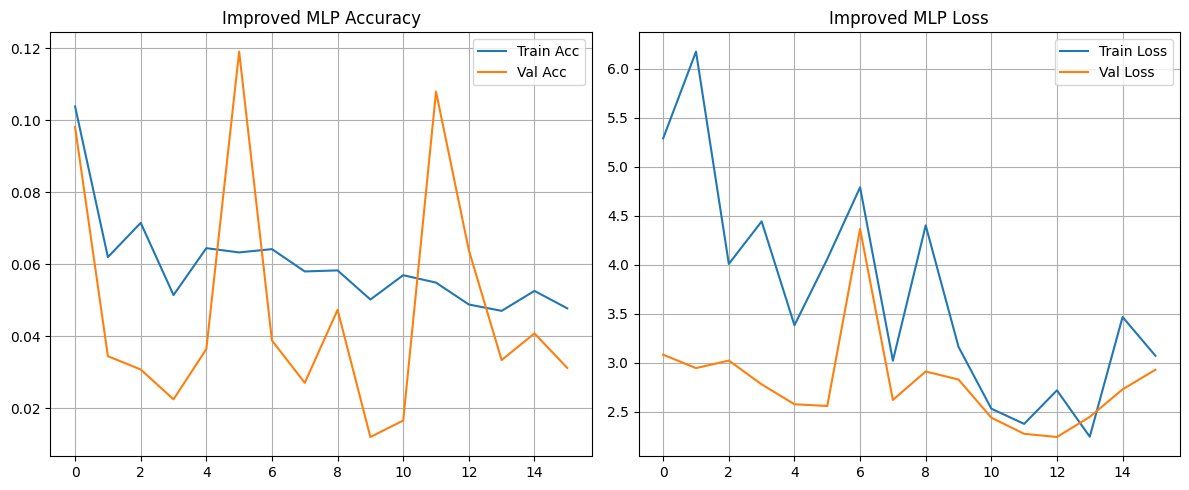

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

MLP Classification Report:
                    precision    recall  f1-score   support

          backdoor       0.15      0.05      0.07      1466
       cryptominer       0.00      0.25      0.00         4
        downloader       0.01      0.08      0.02       206
           dropper       0.02      0.10      0.03       143
           exploit       0.00      0.00      0.00         2
informationstealer       0.01      0.03      0.02        90
          p2p-worm       0.00      0.00      0.00         3
               pua       0.00      0.17      0.00         6
        ransomware       0.01      0.01      0.01       164
           rootkit       0.00      0.00      0.00         1
            trojan       0.53      0.20      0.29      5995
  trojan-gamethief       0.00      0.00      0.00         1
             virus       0.00      0.00      0.00        38
              worm       0.39      0.04      0.07      3340

          accuracy           

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    Conv1D, GlobalAveragePooling1D, ReLU, Add
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CONFIG
FEATURES_DIR = Path("features")
MODELS_DIR = Path("models/deep_learning_improved")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
EPOCHS = 80
BATCH_SIZE = 64
print("Setup complete.")

def plot_learning_curves(history, model_name):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist["accuracy"], label="Train Acc")
    plt.plot(hist["val_accuracy"], label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist["loss"], label="Train Loss")
    plt.plot(hist["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

X = pd.read_pickle(FEATURES_DIR / "X_features.pkl")
y_raw = pd.read_pickle(FEATURES_DIR / "y_labels.pkl")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y_cat = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y_cat, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Data prepared. Shape: {X_train.shape}, Classes: {num_classes}")

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights computed for imbalance correction.")

def build_mlp(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(1024, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=AdamW(learning_rate=1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def resnet_block(x, filters, kernel_size=3):
    fx = Conv1D(filters, kernel_size, padding="same")(x)
    fx = BatchNormalization()(fx)
    fx = ReLU()(fx)
    fx = Conv1D(filters, kernel_size, padding="same")(fx)
    fx = BatchNormalization()(fx)
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding="same")(x)
    out = Add()([x, fx])
    out = ReLU()(out)
    return out

def build_resnet1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 5, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    for _ in range(3):
        x = resnet_block(x, 64)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=AdamW(learning_rate=1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

#CALLBACKS
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

#TRAIN MLP 
print("\nTraining MLP ...")
mlp_model = build_mlp((X_train.shape[1],), num_classes)
mlp_history = mlp_model.fit(
    X_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.1, verbose=1,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
plot_learning_curves(mlp_history, "Improved MLP")

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(mlp_model.predict(X_test), axis=1)
print("\nMLP Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))
mlp_model.save(MODELS_DIR / "mlp_improved.keras")
print("MLP saved.\n")

#TRAIN RESNET1D 
print("\nTraining ResNet1D ...")
X_train_res = np.expand_dims(X_train, axis=-1)
X_test_res = np.expand_dims(X_test, axis=-1)
resnet_model = build_resnet1d(X_train_res.shape[1:], num_classes)
resnet_history = resnet_model.fit(
    X_train_res, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.1, verbose=1,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
plot_learning_curves(resnet_history, "Improved ResNet1D")

y_pred_res = np.argmax(resnet_model.predict(X_test_res), axis=1)
print("\nResNet1D Classification Report:")
print(classification_report(y_true, y_pred_res, target_names=label_encoder.classes_, zero_division=0))
resnet_model.save(MODELS_DIR / "resnet1d_improved.keras")
print("ResNet1D saved successfully.")
